In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno #to visualize missing data

# Iterative Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Miss Forest Imputation
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor 

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import scipy.stats as stats
import pylab

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [209]:
df = pd.read_csv('train.csv')
df.drop(['id', 'Offer %'], axis='columns', inplace=True)


# I temporarily did not drop title column because it helped me understand null values
# Dropped Offer % as it wont be useful to train model and is connected to output price1
print(df.shape)
df.head()

(15730, 14)


,title,Rating,maincateg,platform,price1,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,77.0,3.0,35.0,21.0,7.0,7,7,1


In [210]:
#Renaming columns for convinience
df.rename(columns = {'maincateg':'Gender','norating1':'num_rating', 'noreviews1':'num_reviews','actprice1':'actual_price'}, inplace = True)

In [211]:
df.columns

Index(['title', 'Rating', 'Gender', 'platform', 'price1', 'actual_price',
       'num_rating', 'num_reviews', 'star_5f', 'star_4f', 'star_3f', 'star_2f',
       'star_1f', 'fulfilled1'],
      dtype='object')

In [212]:
df.describe()

,Rating,price1,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
count,15730.000000,15730.000000,15730.000000,15052.000000,15152.000000,15142.000000,15191.000000,15499.000000,15730.000000,15730.000000,15730.000000
mean,4.012873,688.070693,1369.286777,3057.660776,423.976307,1585.239466,655.923310,357.260662,155.085188,275.500572,0.601526
std,0.298440,649.409586,1240.900227,11846.965689,1768.230384,6177.476241,2855.735531,1402.246610,558.650254,958.589075,0.489600
min,0.000000,69.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.900000,349.000000,699.000000,63.000000,9.000000,30.000000,12.000000,7.000000,3.000000,6.000000,0.000000
50%,4.000000,474.000000,999.000000,308.000000,44.000000,150.000000,60.000000,34.000000,17.000000,30.000000,1.000000
75%,4.200000,699.000000,1299.000000,1526.000000,215.000000,788.000000,300.000000,172.000000,77.000000,140.000000,1.000000
max,5.000000,5998.000000,13499.000000,289973.000000,45448.000000,151193.000000,74037.000000,34978.000000,11705.000000,18060.000000,1.000000


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15730 entries, 0 to 15729
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         15730 non-null  object 
 1   Rating        15730 non-null  float64
 2   Gender        15204 non-null  object 
 3   platform      15730 non-null  object 
 4   price1        15730 non-null  int64  
 5   actual_price  15730 non-null  int64  
 6   num_rating    15052 non-null  float64
 7   num_reviews   15152 non-null  float64
 8   star_5f       15142 non-null  float64
 9   star_4f       15191 non-null  float64
 10  star_3f       15499 non-null  float64
 11  star_2f       15730 non-null  int64  
 12  star_1f       15730 non-null  int64  
 13  fulfilled1    15730 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.7+ MB


In [214]:
df.isnull().sum()

title             0
Rating            0
Gender          526
platform          0
price1            0
actual_price      0
num_rating      678
num_reviews     578
star_5f         588
star_4f         539
star_3f         231
star_2f           0
star_1f           0
fulfilled1        0
dtype: int64

In [215]:
#copy of train.csv just to plot data later

data = pd.read_csv('train.csv')
data.drop('id', axis='columns', inplace = True)


data.head()

,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


In [216]:
#Converting offer % columns to float data type
data['Offer %'] = data['Offer %'].str.replace('%', '').astype('float')

In [217]:
#Renaming columns for convinience
data.rename(columns = {'maincateg':'Gender', 'Offer %':'Offer','norating1':'num_rating', 'noreviews1':'num_reviews','actprice1':'actual_price'}, inplace = True)

In [218]:
data.columns

Index(['title', 'Rating', 'Gender', 'platform', 'price1', 'actual_price',
       'Offer', 'num_rating', 'num_reviews', 'star_5f', 'star_4f', 'star_3f',
       'star_2f', 'star_1f', 'fulfilled1'],
      dtype='object')

# Exploratory Data Analysis

<AxesSubplot:>

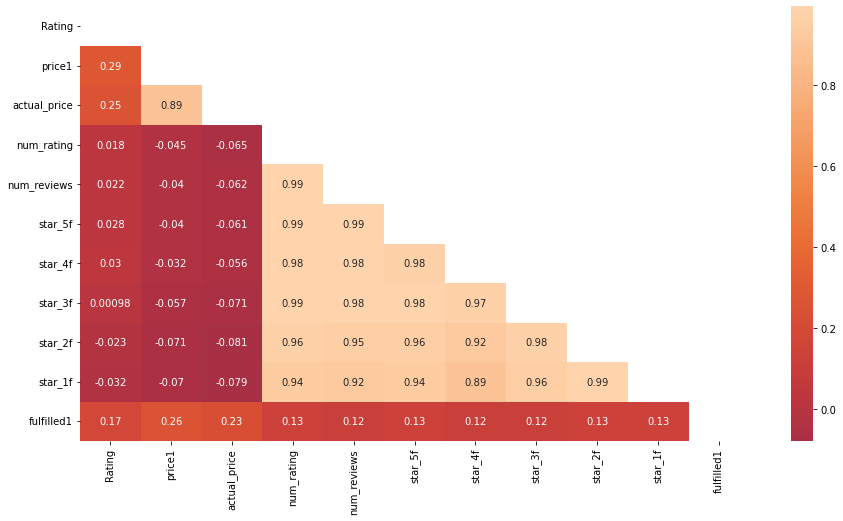

In [12]:
mask = np.triu(np.ones_like(df.corr()))
plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), mask = mask, annot = True, center = -1)

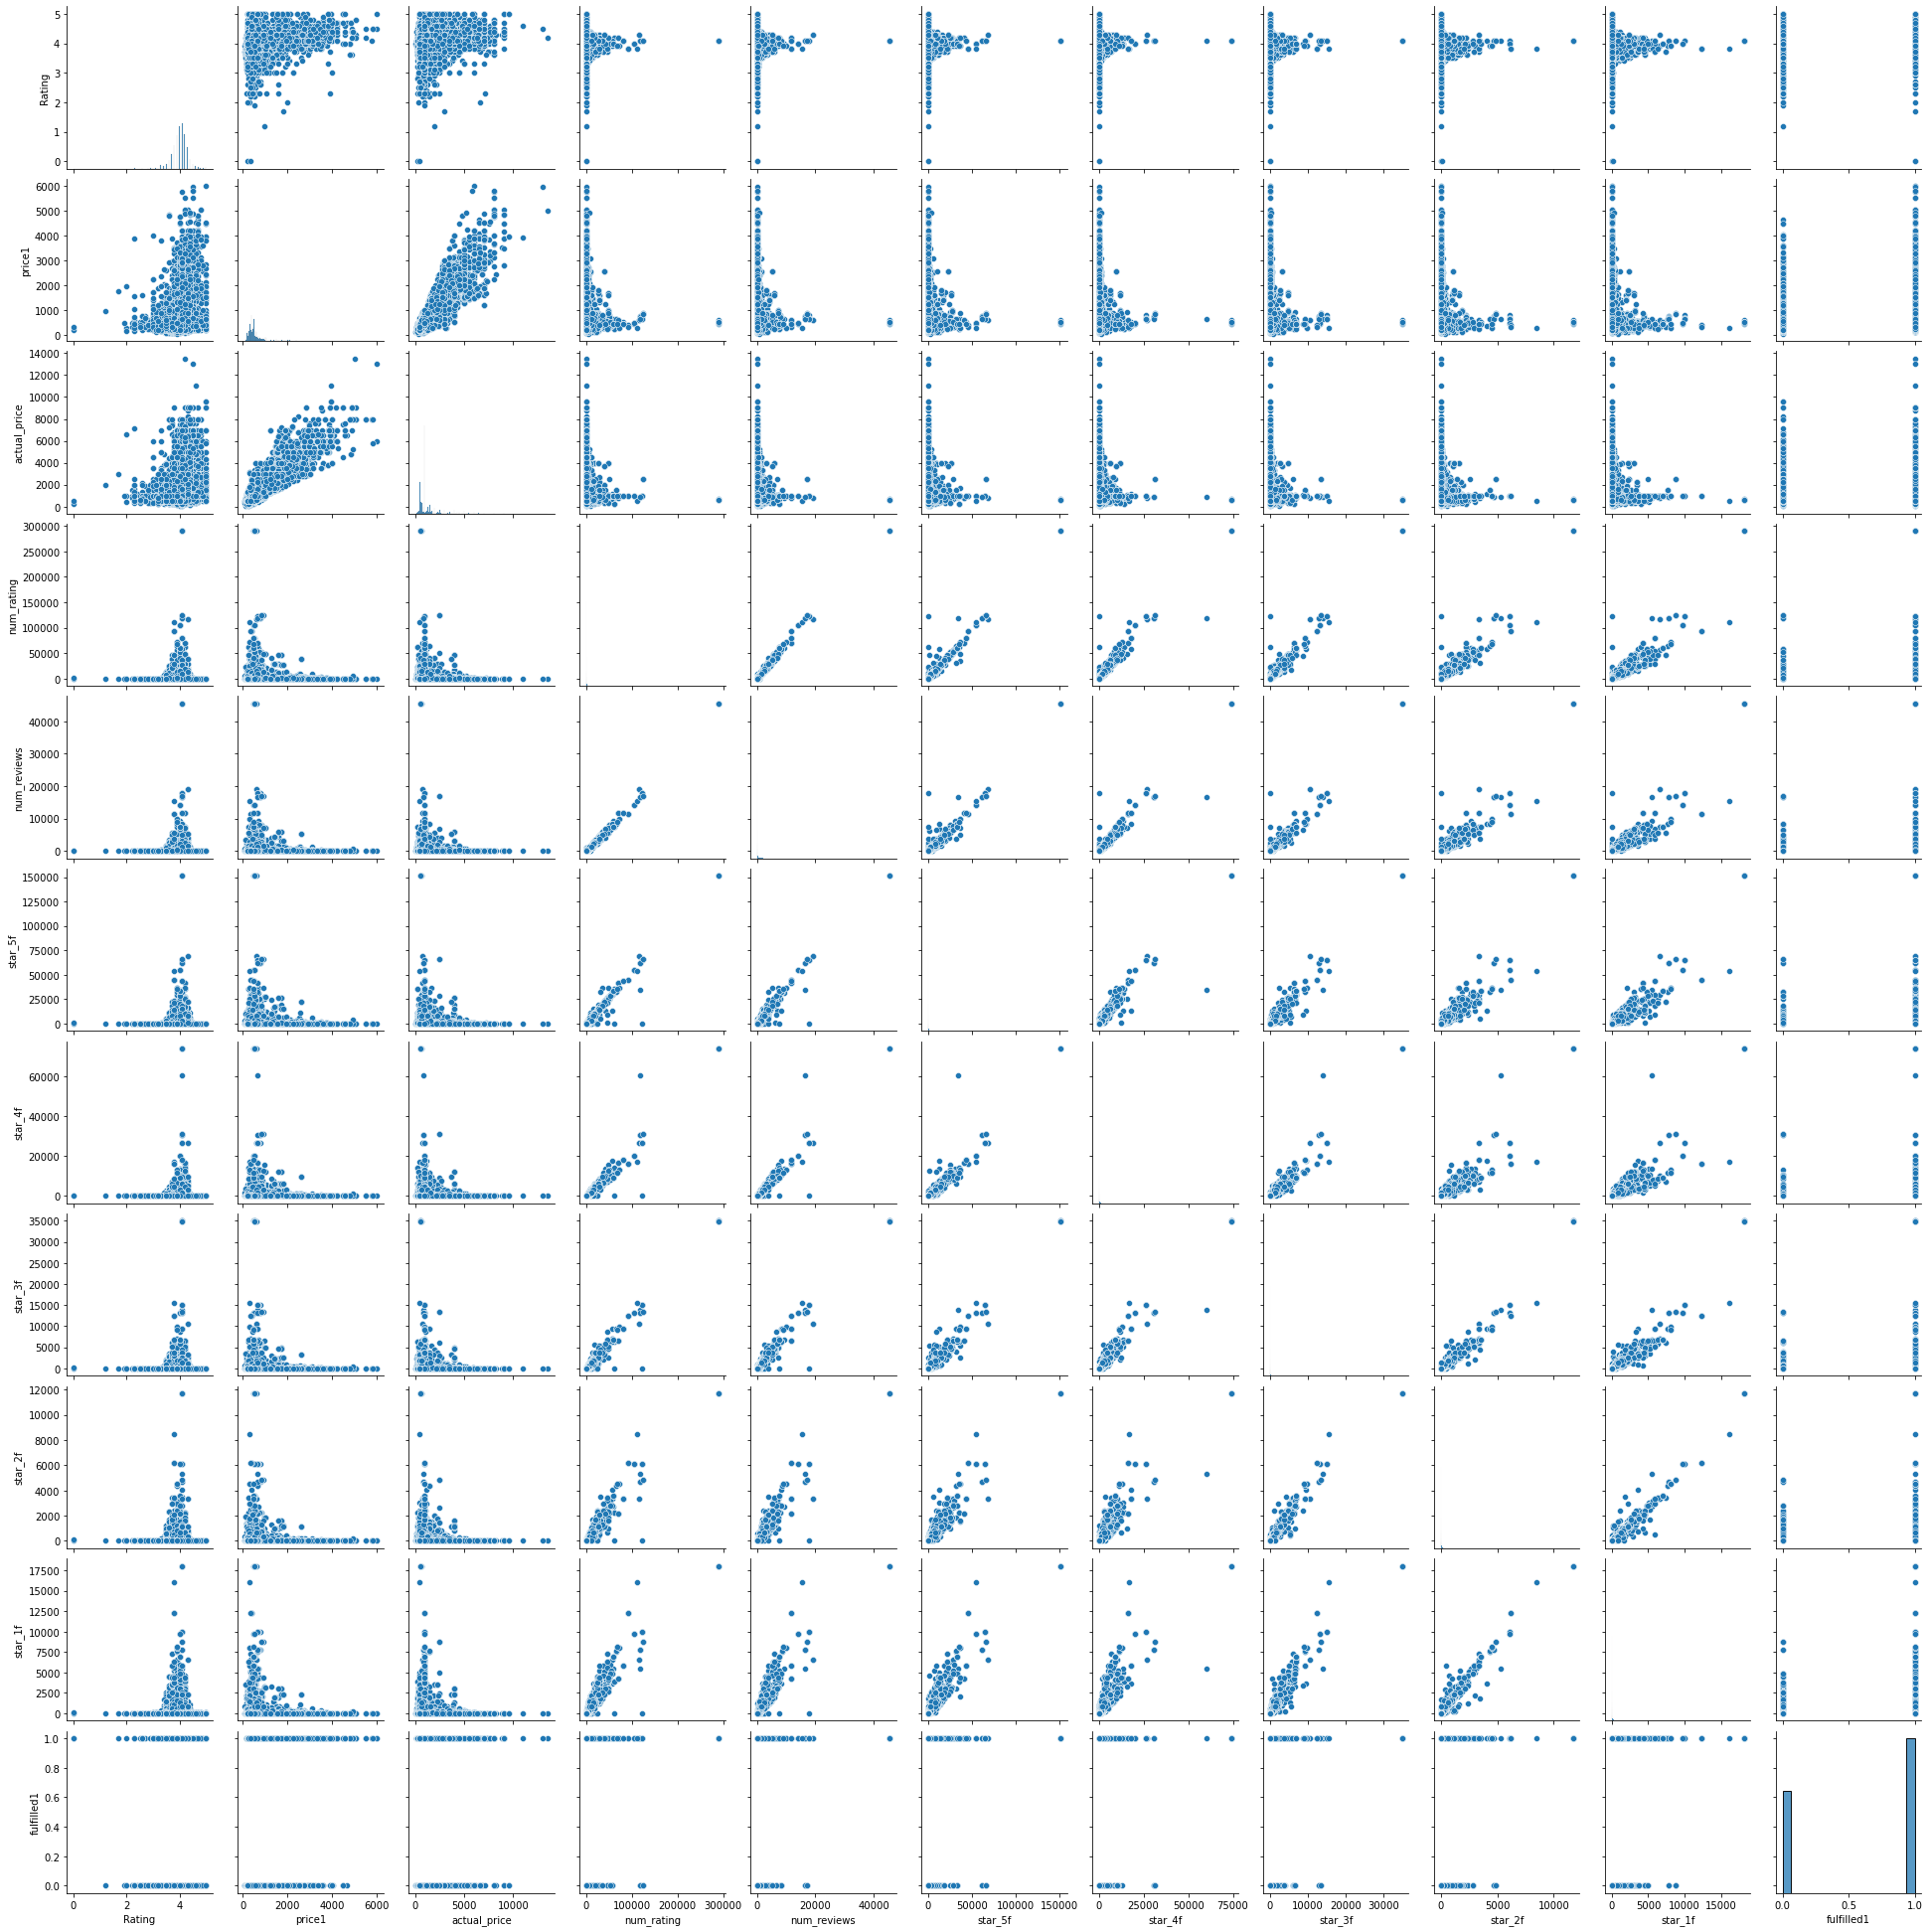

In [13]:
sns.pairplot(df)

The main conclusion I was able to make from this was that XGBRegressor or RandomForestRegressor is the best suited model to impute star_f, num_rating, num_reviews columns.

Also distribution of data from all star_f columns is identical nature, this can also be inferred from the correlation matrix which shows that all star_f columns, num_rating and num_reviews is highly correlated data

In [14]:
categorical_cols = [col for col in data.columns if data[col].dtype in ['object']]
numerical_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

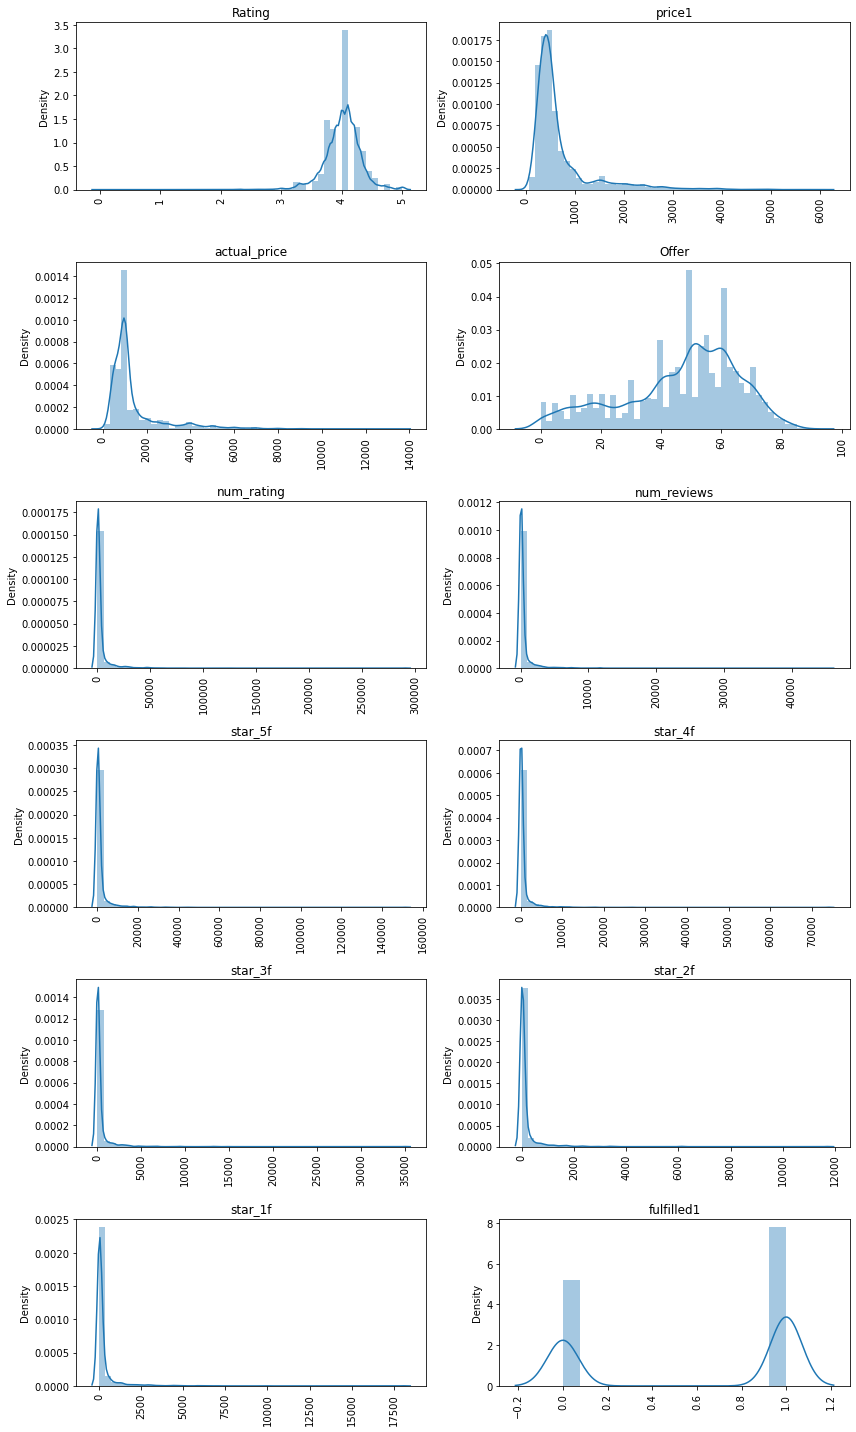

In [15]:
#kdeplot for numerical variables
fig=plt.figure(figsize=(12, 20))
for idx, column in enumerate(numerical_cols):
    plt.subplot(6,2,idx+1)
    sns.distplot(x=data[column], kde = True)
    plt.title(column)     
    plt.xticks(rotation=90)
    plt.tight_layout()

Distribution of Rating column is very close to a normal distibution

The distribution of num_rating and num_reviews column is heavily skewed, this is because of a continuous distribution of outliers from 5000-30000 while most of the data is in less than 1000 range

Distribution of star_f columns is also heavily skewed

actual_price and price1 are not 'perfect' normal distributions and are slightly skewed

Offer % is a column that will not be used as it is not provided in testing data, its just easier to understand

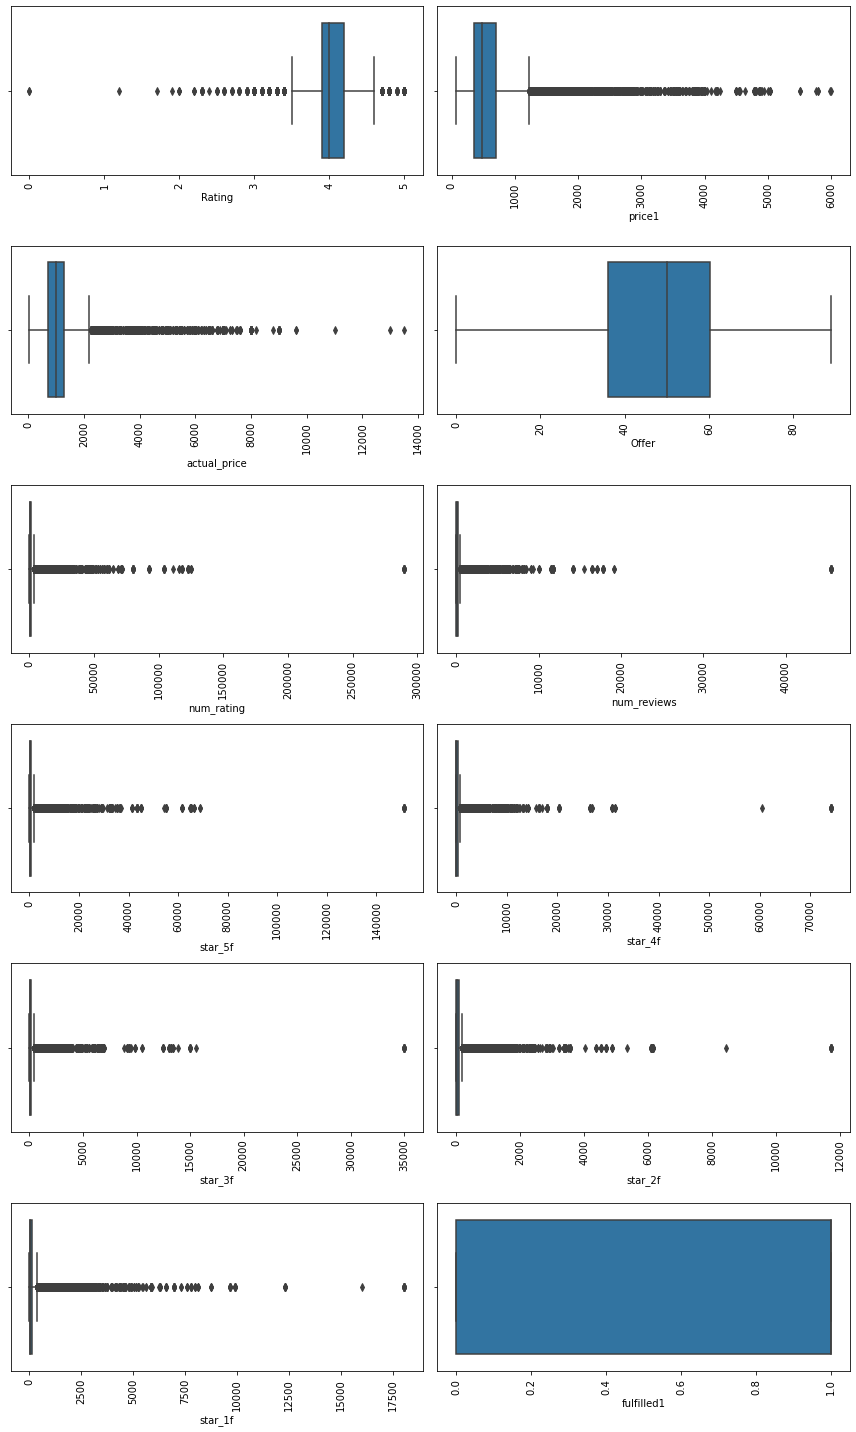

In [16]:
#boxplot for numerical variables
fig=plt.figure(figsize=(12, 20))
for idx, column in enumerate(numerical_cols):
    plt.subplot(6,2,idx+1)
    sns.boxplot(x=data[column],data=data)    
    plt.xticks(rotation=90)
    plt.tight_layout()

I could not think of any good changes to implement on the num_rating and num_reviews column because this sort of distribution is expected and I cannot drop data as outliers, as there will be products that sell more and have more number of reviews & rating but that does not tell us much about quality of product or expected offer % on that product, it only tells that this product is well marketed and sold more units

<AxesSubplot:title={'center':'Discounted Price'}, xlabel='price1', ylabel='Density'>

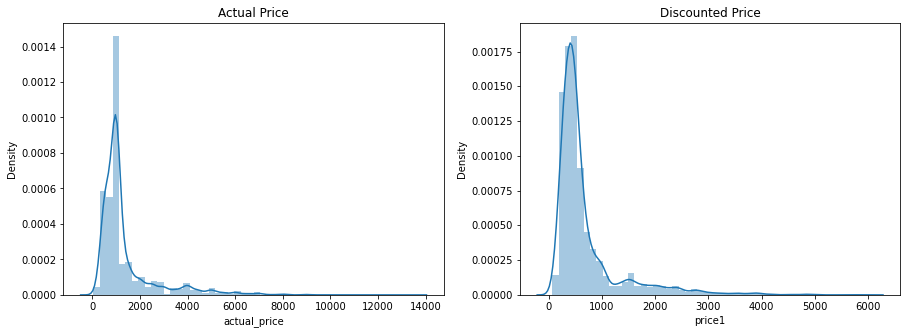

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Actual Price')
sns.distplot(data['actual_price'])

plt.subplot(1,2,2)
plt.title('Discounted Price')
sns.distplot(data['price1'])

Looking at the distribution of these 2 columns, I decided to try making actual_price column more normally distributed as that would help the model and would also match the distribution of output column price1 better.

To start I made some qq plots and tried some feature transformations

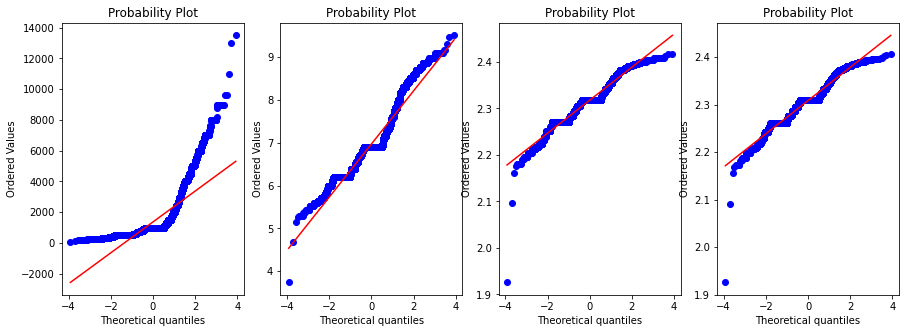

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
stats.probplot(data['actual_price'],plot=pylab)   # No Transformation

plt.subplot(1,4,2)
stats.probplot(np.log(data['actual_price']),plot=pylab)   # Log Transformation

var, _ = stats.boxcox(data['actual_price'])
plt.subplot(1,4,3)
stats.probplot(var,plot=pylab)   # BoxCox Transformation

var, _ = stats.yeojohnson(data['actual_price'])
plt.subplot(1,4,4)
stats.probplot(var,plot=pylab)   # YeoJohnson Transformation

plt.show()

- Based on these transformations I added logprice column by taking log of actual_price column
- I didn't drop actual_price beacuse price1 column is generated by transforming act_price

In [219]:
df['logprice'] = np.log(df['actual_price'])

log transformation improved the MSE score from 186 to 171 and adjusted R-squared from 0.91 to 0.93

# Null Values Imputation

In [220]:
df.isnull().sum(axis='columns').sum()

3140

~20% rows has null values, I will first do some basic data plots and then handle null values

Text(0.5, 1.0, 'Missing Data')

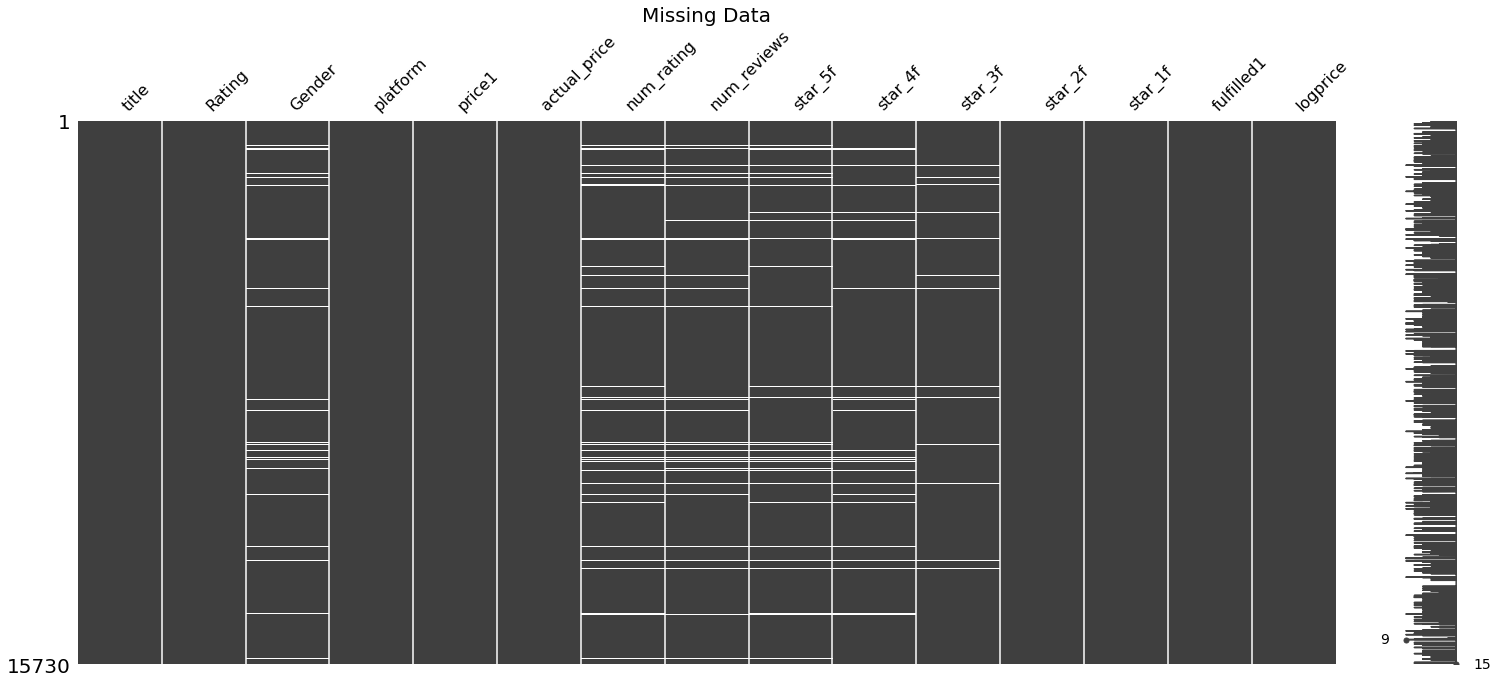

In [221]:
plt_missing = msno.matrix(df)

plt_missing.set_title("Missing Data",fontsize=20)

In [222]:
df.isnull().sum()

title             0
Rating            0
Gender          526
platform          0
price1            0
actual_price      0
num_rating      678
num_reviews     578
star_5f         588
star_4f         539
star_3f         231
star_2f           0
star_1f           0
fulfilled1        0
logprice          0
dtype: int64

In [223]:
df['fulfilled1']=df['fulfilled1'].fillna(0)

### Gender Null Values

In [224]:
df['Gender'].unique()

array(['Women', 'Men', nan], dtype=object)

In [225]:
df[df['Gender'].isnull()].tail()

,title,Rating,Gender,platform,price1,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,logprice
15536,Slides,4.5,NaN,Flipkart,499,799,NaN,1.0,23.0,NaN,1.0,1,2,0,6.683361
15570,Women Multicolor Bellies Sandal,3.7,NaN,Flipkart,501,999,NaN,NaN,NaN,141.0,111.0,75,128,1,6.906755
15583,Jutis For Men (Black),3.7,NaN,Flipkart,494,499,NaN,NaN,22.0,NaN,4.0,4,8,0,6.212606
15674,Zod Runner V3 Wn s IDP Running Shoes For Women...,4.3,NaN,Flipkart,1699,3999,NaN,NaN,NaN,NaN,268.0,102,140,1,8.293800
15709,Enzo Beta Wn's Basketball Shoes For Women (Br...,3.9,NaN,Flipkart,1701,5499,NaN,NaN,NaN,NaN,6.0,2,10,1,8.612322


If Gender is not given we can still figure out Men/Women from title

In [226]:
df.loc[df['title'].str.upper().str.contains('WOMEN') & df['Gender'].isnull(), 'Gender'] = 'Women'
df.loc[df['title'].str.upper().str.contains('MEN') & df['Gender'].isnull(), 'Gender'] = 'Men'
df['Gender'].isnull().sum()

57

In [227]:
df[df['Gender'].isnull()]

,title,Rating,Gender,platform,price1,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,logprice
91,Slippers,3.6,NaN,Flipkart,213,249,NaN,NaN,NaN,NaN,466.0,281,476,1,5.517453
228,Slippers,3.8,NaN,Flipkart,141,499,NaN,23.0,71.0,NaN,22.0,14,17,0,6.212606
728,Slides,3.7,NaN,Flipkart,419,998,NaN,4.0,NaN,NaN,NaN,3,4,1,6.905753
842,Slides,3.9,NaN,Flipkart,2110,2995,NaN,1.0,NaN,NaN,0.0,1,1,1,8.004700
1056,Flip Flops,3.8,NaN,Flipkart,326,499,NaN,NaN,NaN,21.0,NaN,2,10,0,6.212606
1095,Flip Flops,4.2,NaN,Flipkart,1047,1799,NaN,7.0,NaN,NaN,5.0,3,2,1,7.494986
1283,Slippers,4.4,NaN,Flipkart,599,1199,NaN,17.0,NaN,NaN,NaN,3,2,1,7.089243
1288,Slippers,4.3,NaN,Flipkart,599,1199,NaN,NaN,NaN,NaN,NaN,3,5,1,7.089243
1646,Flip Flops,3.4,NaN,Flipkart,498,1497,NaN,7.0,NaN,NaN,8.0,8,23,1,7.311218
2029,Flip Flops,3.6,NaN,Flipkart,99,499,NaN,14.0,NaN,NaN,NaN,6,8,0,6.212606


The remaining of the null values in maincateg are unisexual products like slippers

In [228]:
df.loc[df['Gender'].isnull(), 'Gender'] = 'Unisex'
print(df['Gender'].isnull().sum())
print(df['Gender'].unique())

0
['Women' 'Men' 'Unisex']


I decided to impute the null values using Miss Forest Imputation

In [229]:
#To fit MissForest I temporarily dropped the categorical columns
df_miss = df.drop(['Gender', 'platform', 'title'], axis = 'columns')

## Main Imputation Step

In [230]:
# imputer = IterativeImputer(estimator=XGBRegressor(n_estimators=1000,tree_method='gpu_hist', predictor="gpu_predictor"),max_iter=20,verbose = 2)
# df_imputed = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

Both the imputation techniques works equivalently. Although Iterative Imputer with XGBoostRegressor model works slightly better than MissForest  but it takes more time to run.

In [231]:
#miss forest
imputer = MissForest(max_features='sqrt', bootstrap=False, random_state = 22) #miss forest

In [232]:
df_imputed = pd.DataFrame(imputer.fit_transform(df_miss), columns = df_miss.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


In [233]:
df_imputed['title'] = df['title']

In [234]:
df_imputed['Gender'] = df['Gender']

In [235]:
df_imputed['platform'] = df['platform']

In [236]:
df_imputed.isnull().sum()

Rating          0
price1          0
actual_price    0
num_rating      0
num_reviews     0
star_5f         0
star_4f         0
star_3f         0
star_2f         0
star_1f         0
fulfilled1      0
logprice        0
title           0
Gender          0
platform        0
dtype: int64

# Making Features from title 

So my initial idea was to look for words that are related to offers/discounts

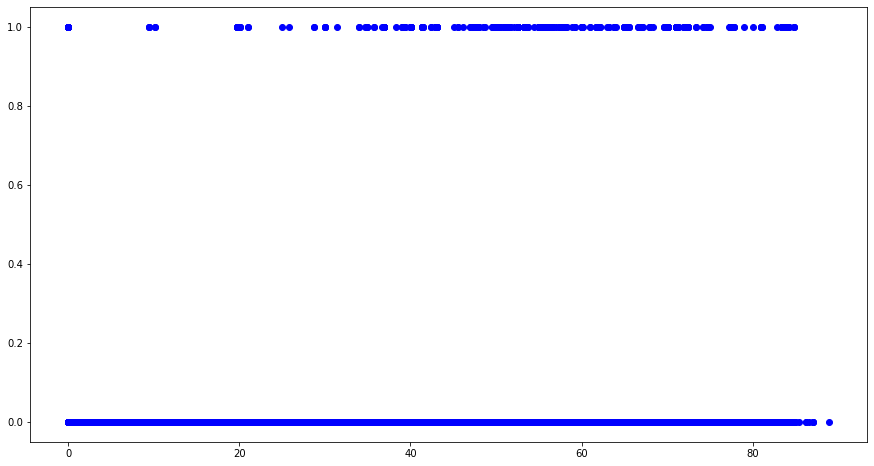

In [237]:
plt.figure(figsize=(15,8))
plt.plot(data['Offer'], data['title'].str.upper().str.contains('COMBO').astype(int), 'bo')

From this plot, it seems like product listings with the word 'Combo' are more likely to give high offers, so i added a column combo telling whether the title contains the word combo 

In [238]:
df_imputed['combo'] = df_imputed['title'].str.upper().str.contains('COMBO').astype(int)

Using title column I also divided the data into different footwear types like Shoe/Sandal/Sneaker/Chappal

In [239]:
df_imputed['sandal'] = df_imputed['title'].str.upper().str.contains('SANDAL').astype(int)
df_imputed['sneaker'] = df_imputed['title'].str.upper().str.contains('SNEAKER').astype(int)
df_imputed['shoe'] = df_imputed['title'].str.upper().str.contains('SHOE').astype(int)
df_imputed['chappal'] = (df_imputed['title'].str.upper().str.contains('SLIPPERS') | df_imputed['title'].str.upper().str.contains('SLIDES') | df_imputed['title'].str.upper().str.contains('FLIP FLOPS')).astype(int)

Ultimately I decided that to extract all data from title by looking at most frequent words of title

In [240]:
# 100 most frequent words in title column

from collections import Counter

arr = []
for i in data['title'].str.split(' '):
    arr += i

c = Counter(arr)    
c_list = c.most_common(100)
c_list

# words = []

# for wd in  c_list:
#     words.append(wd[0])
        
# print(words)

[('For', 10241),
 ('Sandal', 4194),
 ('Shoes', 4163),
 ('Women', 3976),
 ('Running', 2024),
 ('Sneakers', 1806),
 ('Men', 1580),
 ('Black', 1499),
 ('Boots', 1471),
 ('Casual', 1454),
 ('Men\xa0\xa0(Black)', 1454),
 ('Bellies', 1093),
 ('for', 1080),
 ('Jutis', 1073),
 ('Flats', 1054),
 ('Heels', 1008),
 ('Women\xa0\xa0(Black)', 967),
 ('Flip', 894),
 ('Wedges', 875),
 ('Flops', 843),
 ('Stylish', 830),
 ('Walking', 775),
 ('Slip', 711),
 ('Slippers', 679),
 ('On', 663),
 ('Sports', 653),
 ('&', 639),
 ('Slides', 618),
 ('Casuals', 614),
 ('shoes', 593),
 ('Girls', 592),
 ('Women\xa0\xa0(Pink)', 578),
 ('Men\xa0\xa0(Brown)', 529),
 ('|', 505),
 ('Leather', 469),
 ('of', 458),
 ('Mojaris', 458),
 ('Pink', 455),
 ("Men's", 445),
 ('Women\xa0\xa0(Multicolor)', 442),
 ('Lace', 435),
 ('Brown', 435),
 ('Women\xa0\xa0(White)', 432),
 ('and', 430),
 ('Combo', 403),
 ('Grey', 378),
 ('Blue', 371),
 ('Pack', 361),
 ('Women\xa0\xa0(Grey)', 360),
 ('Men\xa0\xa0(Blue)', 356),
 ('High', 351),
 ('La

I then created a list called sp_cols of 100 most frequent words and dropped words like:

    - Un-important words like for, of, on....
    - Repeated things like men/women, combo, sandals....
    - Non descriptive words like Latest/Stylish/Perfect that dont describe the product

In [241]:
# # sp_cols = ['Running', 'Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Walking', 'Slip', 'Sports', 'Casuals', 'Grey', 'Blue', 'Beige', 'Red', 'Brown']
ver_1 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Combo', 'Grey', 'Blue', 'Pack', 'High', 'Latest', 'Loafers', 'Beige', 'Comfortable', 'White', 'Red', 'Ethnic', 'Multicolor', 'Wear', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Perfect', 'Training', 'IDP', 'Gym', 'Partywear', 'Jutti', 'Ankle', 'Shoe', 'New', 'Fashionable', 'Navy', 'Design', 'Lightweight', 'Derby', ]
ver_colour = ['Black', 'Pink', 'Brown', 'Grey', 'Blue', 'Beige', 'White', 'Red', 'Multicolor','Tan', 'Gold', 'Navy']
ver_2 = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Grey', 'Blue', 'Pack', 'Loafers', 'Beige', 'White', 'Red', 'Ethnic', 'Multicolor', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Training', 'IDP', 'Gym', 'Jutti', 'Ankle', 'New', 'Navy', 'Lightweight', 'Derby']


sp_cols = ver_2 

for cl in sp_cols:
    df_imputed[cl] = df_imputed['title'].str.upper().str.contains(cl.upper()).astype(int)

In [242]:
# Just to check that all strings had correct spelling in list
for cl_ck in sp_cols:
    if df_imputed[cl_ck].sum() == 0:
        print(cl_ck)

In [243]:
df_imputed.drop('title', axis='columns', inplace=True)

# Model

## Pipeline

In [244]:
col_enc = make_column_transformer((OneHotEncoder(), ['Gender', 'platform']), remainder='passthrough')

In [245]:
df_imputed.shape

(15730, 62)

In [246]:
df_imputed.head()

,Rating,price1,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,698.0,999.0,38.0,7.0,17.0,9.0,6.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,3.8,999.0,1999.0,531.0,69.0,264.0,92.0,73.0,29.0,73.0,...,0,0,0,0,0,0,0,0,0,0
2,4.4,2749.0,4999.0,17.0,4.0,11.0,3.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4.2,518.0,724.0,46413.0,6229.0,1045.0,12416.0,5352.0,701.0,4595.0,...,0,0,0,0,0,0,0,0,0,0
4,3.9,1379.0,2299.0,77.0,3.0,35.0,21.0,7.0,7.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [247]:
X = df_imputed.drop('price1', axis='columns')
y = df_imputed['price1']

In [267]:
from sklearn.preprocessing import PowerTransformer

In [275]:
from sklearn.preprocessing import StandardScaler

In [276]:
transformer = StandardScaler()

In [268]:
transformer = PowerTransformer(method='yeo-johnson')

In [269]:
from sklearn.decomposition import PCA

In [270]:
pca = PCA(n_components=15)

## RandomForestRegressor

In [ ]:
# Model after GridSearchCV hyperparametertuning

In [ ]:
rand_forest = RandomForestRegressor(n_jobs=-1, random_state=22)

In [ ]:
# Created pipeline
rand_forest_pipe = make_pipeline(col_enc, rand_forest)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {'randomforestregressor__bootstrap': [False, True],
 'randomforestregressor__min_samples_split': [2,3,4,5],
 'randomforestregressor__max_features': [2,4,6,8],
 'randomforestregressor__max_depth': [None,3,5,7],
 'randomforestregressor__n_estimators': [800,900,1000]}

# Instantiate the grid search model
# grid_search_rand = GridSearchCV(estimator = rand_forest_pipe, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search_rand = RandomizedSearchCV(estimator = rand_forest_pipe, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=22, n_jobs = -1)

grid_search_rand.fit(X, y)
# best_model_rand = grid_search_rand.best_estimator_

In [ ]:
grid_search_rand.best_params_

In [277]:
#entered best parameters
rand_forest = RandomForestRegressor(bootstrap=False, max_features=8, min_samples_split=2, max_depth = None,
                      n_estimators=800, n_jobs=-1, random_state=22)

In [278]:
# Created pipeline
rand_forest_pipe = make_pipeline(col_enc, transformer, pca, rand_forest)

In [279]:
rand_forest_pipe_mse = -1*cross_val_score(rand_forest_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
rand_forest_pipe_mse.mean()

204.49799355880955

In [ ]:
rand_forest_pipe_r2 = cross_val_score(rand_forest_pipe, X, y, cv=5, scoring='r2')
rand_forest_pipe_r2.mean()

In [167]:
n,p = X.shape

In [168]:
adj_r2 = 1-((1-rand_forest_pipe_r2)*(n-1)/(n-p-1))

In [169]:
adj_r2.mean()

0.9304318781059173

## XGBoostRegressor

In [59]:
xgb = XGBRegressor(random_state = 22)

In [60]:
# Created pipeline 
xgb_pipe = make_pipeline(col_enc, xgb)

In [61]:
param_grid = {'xgbregressor__gamma': [0, 0.05, 0.1, 0.2],
              'xgbregressor__learning_rate': [0.05, 0.1, 0.2],
              'xgbregressor__max_depth': [2, 4, 6, 8, 10, 12],
              'xgbregressor__max_leaves': [0, 1, 2, 3, 4, 5],
              'xgbregressor__min_child_weight': [1.0, 2.0, 3.0],
              'xgbregressor__n_estimators': [200, 400, 600, 800, 1000]}

# Instantiate the grid search model
# grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, verbose=2,  n_jobs = -1)
grid_search_xgb1 = RandomizedSearchCV(estimator = xgb_pipe, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1, random_state=234567)

grid_search_xgb1.fit(X, y)
# best_model_xgb1 = grid_search_xgb1.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'platform'])])),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=No...
                                                           reg_lambda=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'xgbregressor__gamma': [0, 0.05, 0.1,
                                                                0.2],
                                        'xgbregressor__learning_rate': [0.05,
                                                                        0.1,
                                                                        0.2],
                                        'xgbregressor__max_depth': [2, 4, 6, 8,
                                                                    10, 12],
                                        'xgbregressor__max_leaves': [0, 1, 2, 3,
                                                                     4, 5],
                                        'xgbregressor__min_child_weight': [1.0,
                                                                           2.0,
                                                                           3.0],
                                        'xgbregressor__n_estimators': [200, 400,
                                                                       600, 800,
                                                                       1000]},
                   random_state=234567, verbose=2)

In [62]:
grid_search_xgb1.best_params_

{'xgbregressor__n_estimators': 800,
 'xgbregressor__min_child_weight': 2.0,
 'xgbregressor__max_leaves': 4,
 'xgbregressor__max_depth': 8,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__gamma': 0.2}

In [63]:
xgb = XGBRegressor(gamma=0.2,learning_rate=0.1, max_depth=8, max_leaves=4, min_child_weight=2, n_estimators=800, n_jobs=-1, random_state=22)

In [64]:
# Created pipeline 
xgb_pipe = make_pipeline(col_enc, xgb)

In [65]:
xgb_pipe_mse = -1*cross_val_score(xgb_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
xgb_pipe_mse.mean()

178.75657161747318

In [66]:
xgb_pipe_r2 = cross_val_score(xgb_pipe, X, y, cv=5, scoring='r2')
xgb_pipe_r2.mean()

0.9239915673673691

In [67]:
xgb_adj_r2 = 1-((1-xgb_pipe_r2)*(n-1)/(n-p-1))

In [68]:
xgb_adj_r2.mean()

0.9236956448252073

# ExtraTreesRegressor

In [69]:
extra = ExtraTreesRegressor(random_state = 22, n_jobs=-1)

In [70]:
# Created pipeline
extra_pipe = make_pipeline(col_enc, extra)

In [71]:
param_grid = {
    'extratreesregressor__n_estimators': [100,200, 400, 600, 800],
    'extratreesregressor__max_depth': [None,3,5,7,9],
    'extratreesregressor__max_features': [2,4,6,8,10],
    'extratreesregressor__min_samples_leaf': [1,3,5,7],
    'extratreesregressor__min_samples_split': [2,4,6,8],
    'extratreesregressor__bootstrap': [True, False]
    }

# Instantiate the grid search model
# grid_search_xgb = GridSearchCV(estimator = extra, param_grid = param_grid, cv = 3, verbose=2,  n_jobs = -1)
grid_search_extra1 = RandomizedSearchCV(estimator = extra_pipe, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1, random_state=234567)

grid_search_extra1.fit(X, y)
# best_model_extra1 = grid_search_extra1.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['Gender',
                                                                                'platform'])])),
                                             ('extratreesregressor',
                                              ExtraTreesRegressor(n_jobs=-1,
                                                                  random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'extratreesregressor__bootstrap': [True,
                                                                           False],
                                        'extratreesregressor__max_depth': [None,
                                                                           3, 5,
                                                                           7,
                                                                           9],
                                        'extratreesregressor__max_features': [2,
                                                                              4,
                                                                              6,
                                                                              8,
                                                                              10],
                                        'extratreesregressor__min_samples_leaf': [1,
                                                                                  3,
                                                                                  5,
                                                                                  7],
                                        'extratreesregressor__min_samples_split': [2,
                                                                                   4,
                                                                                   6,
                                                                                   8],
                                        'extratreesregressor__n_estimators': [100,
                                                                              200,
                                                                              400,
                                                                              600,
                                                                              800]},
                   random_state=234567, verbose=2)

In [72]:
grid_search_extra1.best_params_

{'extratreesregressor__n_estimators': 100,
 'extratreesregressor__min_samples_split': 4,
 'extratreesregressor__min_samples_leaf': 1,
 'extratreesregressor__max_features': 10,
 'extratreesregressor__max_depth': None,
 'extratreesregressor__bootstrap': False}

In [73]:
extra = ExtraTreesRegressor(n_estimators = 100, min_samples_split = 4, min_samples_leaf = 1, max_features = 10, max_depth = None, bootstrap = False, random_state = 22, n_jobs=-1)

In [74]:
# Created pipeline
extra_pipe = make_pipeline(col_enc, extra)

In [75]:
extra_pipe_mse = -1*cross_val_score(extra_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
extra_pipe_mse.mean()

173.45743685799033

In [76]:
extra_pipe_r2 = cross_val_score(extra_pipe, X, y, cv=5, scoring='r2')
extra_pipe_r2.mean()

0.92846339514942

In [77]:
extra_adj_r2 = 1-((1-extra_pipe_r2)*(n-1)/(n-p-1))

In [78]:
extra_adj_r2.mean()

0.9281848827103157

# Result

In [79]:
result = [['Random Forest Regressor', rand_forest_pipe_mse.mean(), rand_forest_pipe_r2.mean(), adj_r2.mean()], ['XGBoost Regressor', xgb_pipe_mse.mean(), xgb_pipe_r2.mean(), xgb_adj_r2.mean()], ['Extra Trees Regressor', extra_pipe_mse.mean(), extra_pipe_r2.mean(), extra_adj_r2.mean()]]

In [80]:
result = pd.DataFrame(result, columns=['Model Name', 'MSE', 'R_squared', 'Adjusted R_squared'])

In [81]:
result

,Model Name,MSE,R_squared,Adjusted R_squared
0,Random Forest Regressor,170.355285,0.931033,0.930764
1,XGBoost Regressor,178.756572,0.923992,0.923696
2,Extra Trees Regressor,173.457437,0.928463,0.928185


Random Forest Regressor fits best to our data considering all three metrics.

# Test Data

In [82]:
df_test = pd.read_csv('test.csv')
df_test.rename(columns = {'maincateg':'Gender','norating1':'num_rating', 'noreviews1':'num_reviews','actprice1':'actual_price'}, inplace = True)
df_test_id = df_test['id']
df_test.head()

,id,title,Rating,Gender,platform,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,2242,Casuals For Men (Blue),3.8,Men,Flipkart,999,27928,3543,14238.0,4295,3457,1962,3976.0,1
1,20532,Women Black Flats Sandal,3.9,Women,Flipkart,499,3015,404,1458.0,657,397,182,321.0,1
2,10648,Women Gold Wedges Sandal,3.9,Women,Flipkart,999,449,52,229.0,70,71,33,46.0,1
3,20677,Men's Height Increasing High Heel Formal Party...,3.9,Men,Flipkart,2999,290,40,141.0,51,49,17,32.0,1
4,12593,Loafers For Men (Tan),3.9,Men,Flipkart,999,2423,326,1265.0,414,293,143,308.0,0


In [83]:
df_test['logprice'] = np.log(df_test['actual_price'])

In [84]:
df_test.isnull().sum()

id                0
title             0
Rating          203
Gender           67
platform          0
actual_price      0
num_rating        0
num_reviews       0
star_5f          68
star_4f           0
star_3f           0
star_2f           0
star_1f         186
fulfilled1        0
logprice          0
dtype: int64

Handled null values same way as done with training data

In [85]:
df_test.loc[df_test['title'].str.upper().str.contains('WOMEN') & df_test['Gender'].isnull(), 'Gender'] = 'Women'
df_test.loc[df_test['title'].str.upper().str.contains('MEN') & df_test['Gender'].isnull(), 'Gender'] = 'Men'
df_test.loc[df_test['Gender'].isnull(), 'Gender'] = 'Unisex'

In [86]:
# To fit MissForest, I temporarily dropped categorical columns
df_test_miss = df_test.drop(['Gender', 'platform', 'title'], axis = 'columns')

### Main Imputation Step

In [87]:
#miss forest
imputer = MissForest(max_features='sqrt', bootstrap=False, random_state = 22) #miss forest

In [88]:
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test_miss), columns = df_test_miss.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [89]:
df_test_imputed['title'] = df_test['title']

In [90]:
df_test_imputed['Gender'] = df_test['Gender']

In [91]:
df_test_imputed['platform'] = df_test['platform']

In [92]:
df_test_imputed.isnull().sum()

id              0
Rating          0
actual_price    0
num_rating      0
num_reviews     0
star_5f         0
star_4f         0
star_3f         0
star_2f         0
star_1f         0
fulfilled1      0
logprice        0
title           0
Gender          0
platform        0
dtype: int64

# Making Features from title

Completing Feature Transformations on testing data

In [93]:
df_test_imputed['combo'] = df_test_imputed['title'].str.upper().str.contains('COMBO').astype(int)

In [94]:
df_test_imputed['sandal'] = df_test_imputed['title'].str.upper().str.contains('SANDAL').astype(int)
df_test_imputed['sneaker'] = df_test_imputed['title'].str.upper().str.contains('SNEAKER').astype(int)
df_test_imputed['shoe'] = df_test_imputed['title'].str.upper().str.contains('SHOE').astype(int)
df_test_imputed['chappal'] = (df_test_imputed['title'].str.upper().str.contains('SLIPPERS') | df_test_imputed['title'].str.upper().str.contains('SLIDES') | df_test_imputed['title'].str.upper().str.contains('FLIP FLOPS')).astype(int)

In [95]:
df_test_imputed.head()

,id,Rating,actual_price,num_rating,num_reviews,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,logprice,title,Gender,platform,combo,sandal,sneaker,shoe,chappal
0,2242.0,3.8,999.0,27928.0,3543.0,14238.0,4295.0,3457.0,1962.0,3976.0,1.0,6.906755,Casuals For Men (Blue),Men,Flipkart,0,0,0,0,0
1,20532.0,3.9,499.0,3015.0,404.0,1458.0,657.0,397.0,182.0,321.0,1.0,6.212606,Women Black Flats Sandal,Women,Flipkart,0,1,0,0,0
2,10648.0,3.9,999.0,449.0,52.0,229.0,70.0,71.0,33.0,46.0,1.0,6.906755,Women Gold Wedges Sandal,Women,Flipkart,0,1,0,0,0
3,20677.0,3.9,2999.0,290.0,40.0,141.0,51.0,49.0,17.0,32.0,1.0,8.006034,Men's Height Increasing High Heel Formal Party...,Men,Flipkart,0,0,0,0,0
4,12593.0,3.9,999.0,2423.0,326.0,1265.0,414.0,293.0,143.0,308.0,0.0,6.906755,Loafers For Men (Tan),Men,Flipkart,0,0,0,0,0


In [96]:
for cl in sp_cols:
    df_test_imputed[cl] = df_test_imputed['title'].str.upper().str.contains(cl.upper()).astype(int)

In [97]:
df_test_imputed.drop(['id','title'], axis='columns', inplace=True)
df_test_imputed.shape

(5244, 61)

In [98]:
rand_forest_pipe.fit(X, y)
y_pred = rand_forest_pipe.predict(df_test_imputed)

In [99]:
df_sub = pd.DataFrame({'id':df_test_id.values, 'price1':y_pred})

In [100]:
df_sub.to_csv('final_submission______4.csv', index=False)

# Failed Idea of Imputation

In [101]:
# To impute missing value using Linear Regression, first we have to Normalize the data
# yeo-johnson Power transformer works well for whole data

In [102]:
# lin_reg = LinearRegression()
# def Fit_impute(X_depend, y_pred):
#     for i in y_pred.columns:
#         if y_pred[i].isnull().sum()>0:
#             null_index = y_pred[y_pred[i].isnull()].index
#             no_null_index = y_pred[i].dropna().index
#             x1 = np.array(X_depend.loc[no_null_index]).reshape(-1,1)
#             y1 = np.array(y_pred.loc[no_null_index, i]).reshape(-1,1)
#             x2 = np.array(X_depend.loc[null_index]).reshape(-1,1)
#             name = str(f'reg_{i}')
#             name = lin_reg.fit(x1, y1)
#             y_pred.loc[null_index, i] = name.predict(x2).reshape(1,-1)
#     return y_pred

In [103]:
# imputed_data = Fit_impute(data1_train.star_2f, data1_train.drop(['star_2f'], axis = 1))